# Transcription factor activity inference

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering transcription factor (TF) activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for TF activity inference with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the **Usage** tutorial first.

</div>  

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

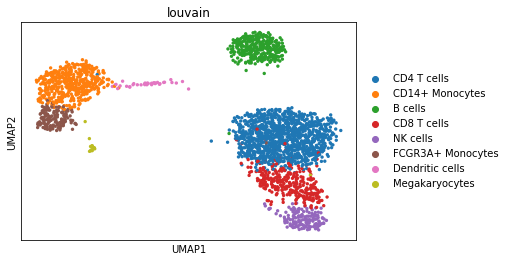

In [3]:
sc.pl.umap(adata, color='louvain')

## DoRothEA network

[DoRothEA](https://saezlab.github.io/dorothea/) is a comprehensive resource containing a curated collection of TFs and their transcriptional targets. Since these regulons were gathered from different types of evidence, interactions in DoRothEA are classified in different confidence levels, ranging from A (highest confidence) to D (lowest confidence). Moreover, each interaction is weighted by its confidence level and the sign of its mode of regulation (activation or inhibition).

For this example we will use the human version (mouse is also available) and we will use the confidence levels ABC. To access it we can use `decoupler`.

In [4]:
net = dc.get_dorothea(organism='human', levels=['A','B','C'])
net

,source,confidence,target,weight
32,ADNP,C,ATF7IP,0.333333
99,ADNP,C,DYRK1A,0.333333
325,ADNP,C,TLK1,0.333333
355,ADNP,C,ZMYM4,0.333333
383,AHR,C,ARHGAP15,0.333333
...,...,...,...,...
277557,ZNF766,C,MARF1,0.333333
277760,ZNF83,C,CUBN,0.333333
277842,ZNF83,C,PCBP1,0.333333
277885,ZNF83,C,SND1,0.333333


## Activity inference with Multivariate Linear Model

To infer activities we will run the Multivariate Linear Model method (`mlm`). It models the observed gene expression by using a regulatory adjacency matrix (target genes x TFs) as covariates of a linear model. The values of this matrix are the associated interaction weights.
The obtained t-values of the fitted model are the activity scores.

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

In [5]:
dc.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True)

58 features of mat are empty in 2635 samples, they will be ignored.
Running mlm on mat with 2638 samples and 13656 targets for 281 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]


The obtained scores (t-values)(`mlm_estimate`) and p-values (`mlm_pvals`) are stored in the `.obsm` key:

In [6]:
adata.obsm['mlm_estimate']

,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,ATF3,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
AAACATACAACCAC-1,1.378135,2.264273,-0.873322,-0.393858,0.138300,-0.672718,-0.517479,-0.248986,3.503265,2.835963,...,0.184587,-0.368374,-2.079961,-0.819101,-1.070376,-0.513939,-0.168147,1.016369,-0.426693,0.321183
AAACATTGAGCTAC-1,-0.771592,1.791025,-0.843771,-2.423655,1.121631,-1.710017,-0.098786,-0.437355,1.153930,0.325601,...,0.975836,-1.015507,-1.298664,-0.695452,-0.717216,-0.854899,-0.634035,-0.014624,0.189121,0.082495
AAACATTGATCAGC-1,1.692710,2.992034,-0.532615,-1.705098,0.845731,-1.167016,-0.788160,1.828757,3.575169,2.071486,...,0.001384,-0.424543,-2.065581,-0.535091,-0.751262,0.057934,0.295792,1.095627,1.089436,1.264037
AAACCGTGCTTCCG-1,0.950064,2.362731,-0.064999,-2.908230,0.925053,-1.022329,-0.007307,0.157366,2.790008,0.088670,...,0.729664,-0.744951,-1.341359,-1.054481,-1.698370,-0.830679,-0.641169,-0.139106,-0.632336,-0.595452
AAACCGTGTATGCG-1,1.064581,1.690591,-0.638252,-1.559646,0.021609,-1.933049,-0.375894,-1.909076,-2.098804,2.609869,...,1.399544,-0.788018,-1.914087,0.276000,-0.631482,-0.596122,0.775489,0.925926,-0.350876,0.218557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.318688,3.333595,-0.411664,-1.804654,-0.024565,-1.428001,-0.363318,-0.074915,1.548303,-1.499557,...,0.924372,0.169212,-1.506868,-1.248334,-0.712812,-0.823596,-0.452081,-0.257280,0.458884,-0.125251
TTTCTACTGAGGCA-1,0.030770,3.491437,-0.003791,-1.533359,1.548976,-1.666779,-0.371404,0.731910,2.437067,-0.304436,...,0.801202,-0.535329,-1.734694,-0.584308,-1.229465,-1.455734,0.495586,1.191117,-0.316089,-0.160711
TTTCTACTTCCTCG-1,0.832445,1.216446,-0.077293,-2.480361,1.021587,-1.059844,-0.543997,0.110234,4.672308,0.357114,...,0.063306,-0.711501,-0.494086,-0.123922,0.307080,-0.587546,-0.336605,-0.489180,-0.105757,0.136211
TTTGCATGAGAGGC-1,1.639155,-1.020706,-0.213240,-1.343566,-1.097421,-1.058532,-0.473836,-1.477254,3.461115,-0.166357,...,0.090237,-0.554044,-1.828985,-0.717352,-1.356452,0.781485,-0.567864,1.205502,-0.513317,-0.485571


## Visualization

To visualize the obtained scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract the activities from the `adata` object.

In [7]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

AnnData object with n_obs × n_vars = 2638 × 281
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'mlm_estimate', 'mlm_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

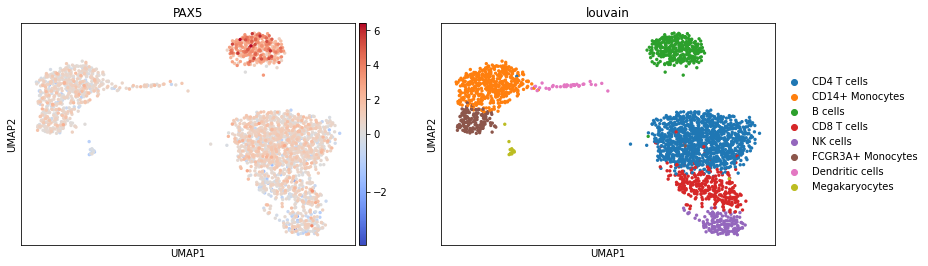

In [8]:
sc.pl.umap(acts, color=['PAX5', 'louvain'], cmap='coolwarm', vcenter=0)

Here we observe the activity infered for PAX5 across cells, which it is particulary active in B cells. Interestingly, PAX5 is a known TF crucial for B cell identity and function.
The inference of activities from "foot-prints" of target genes is more informative than just looking at the molecular readouts of a given TF, as an example here is the gene expression of PAX5, which is not very informative by itself:

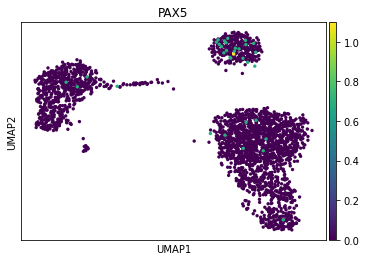

In [9]:
sc.pl.umap(adata, color='PAX5')

## Exploration

With `decoupler` we can also see what is the mean activity per group:

In [10]:
mean_acts = dc.summarize_acts(acts, groupby='louvain', min_std=0.75)
mean_acts

,ATF2,ATF3,BACH2,CEBPB,CREB1,CREM,E2F7,ELK1,ESR2,FLI1,...,REL,RFX5,SPI1,SRF,STAT3,STAT4,TWIST1,USF2,VDR,ZEB2
B cells,2.862969,0.019417,1.465132,-1.228275,0.766851,-1.464812,2.403033,2.052581,3.010641,-1.225937,...,-0.235809,13.664467,1.983899,1.009392,0.446212,-0.634330,-0.379897,1.135778,3.559175,1.004979
CD14+ Monocytes,1.999015,0.171993,2.853407,0.873314,-1.068738,-1.807258,3.214978,1.698306,5.127353,-0.795042,...,-0.484027,6.790155,3.596492,2.012946,1.400468,2.490378,-0.830065,0.463730,3.634538,2.253694
CD4 T cells,2.803929,0.874975,1.300077,-1.456407,-0.922025,-1.801688,2.631588,2.954413,3.755870,-0.997119,...,-0.048043,1.297521,1.478310,1.341560,1.228789,0.390740,-0.088308,1.126815,3.673028,1.261325
CD8 T cells,1.982264,2.649556,1.488398,-1.810813,-0.213380,-1.688925,2.406077,2.480688,4.022677,-0.927005,...,1.185046,2.509189,2.047694,1.809775,0.565882,1.710765,-0.155669,1.347120,3.513262,0.990924
Dendritic cells,2.866910,0.180120,1.889392,-0.742991,-0.417720,-1.442680,3.151726,1.870633,3.726103,-0.932663,...,0.012765,15.064679,3.585426,2.635829,1.193605,1.011143,-0.950943,0.472482,4.095111,2.617521
FCGR3A+ Monocytes,2.293195,0.446685,2.491488,-0.908603,-1.255403,-1.755674,3.188229,1.914760,4.890972,-0.538164,...,-0.813956,7.569206,3.998400,2.627059,2.216235,2.493337,-1.909960,0.895058,3.707707,1.937339
Megakaryocytes,0.040985,2.745287,4.102507,-2.279614,0.885362,0.852620,0.671598,-0.539562,5.077627,2.363788,...,2.611786,2.147288,3.802467,7.185968,-1.160660,-1.038136,-2.471810,3.479990,1.433558,0.918436
NK cells,1.108530,2.085615,1.788462,-1.807450,-0.826896,-2.283547,2.114204,1.565361,4.122882,-1.014565,...,-0.035408,2.060023,2.794983,2.362189,0.249300,3.375606,-0.687442,1.471112,3.432888,0.413902


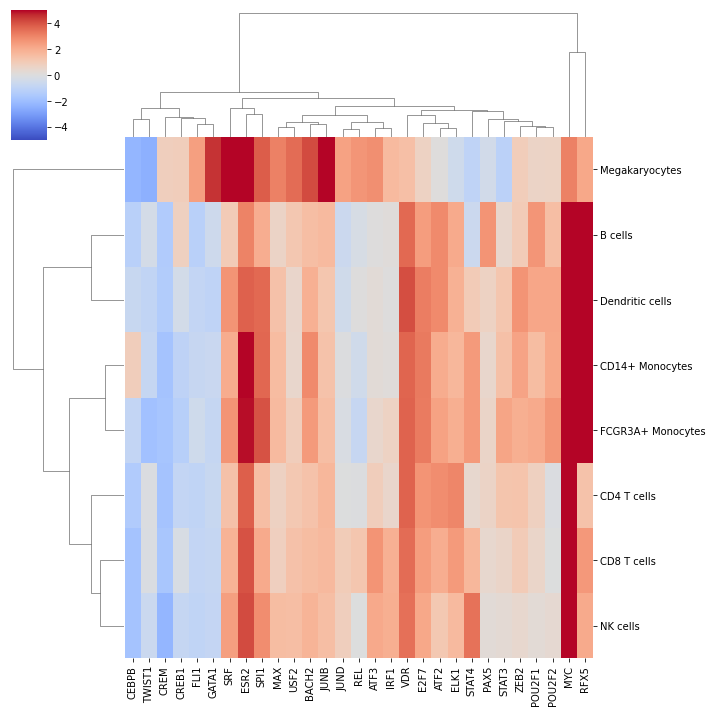

In [11]:
sns.clustermap(mean_acts, xticklabels=mean_acts.columns, vmin=-5, vmax=5, cmap='coolwarm')
plt.show()

Here we can observe other known marker TFs appering, GATA1 for megakaryocytes, RFX5 for the myeloid lineage and JUND for the lymphoid.